<a href="https://www.kaggle.com/code/surekhaberlin/binary-prediction-of-poisonous-mushrooms?scriptVersionId=193144979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


# STEP 0: Importing Libraries

In [2]:
!pip install skimpy
!pip install fastdtw
!pip install colorama

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 44.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: polars
    Found existing installation: polars 1.1.0
    Uninstalling polars-1.1.0:
      Successfully uninstalled polars-1.1.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.

In [3]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Skimpy
import skimpy

# Sklearn (Scikit-learn)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, QuantileTransformer
from sklearn.base import clone
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Statistics
from scipy.stats import friedmanchisquare

# Boosting Models
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Colorama
from colorama import Fore, Style

# Itertools
from itertools import combinations

# Warnings
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)


In [4]:
SUBMIT = True

In [5]:
from bs4 import BeautifulSoup

In [6]:
from colorama import Fore, Style, init

# Initialize colorama
init(autoreset=True)

def printColor(pText: str):
    print(f'{Style.BRIGHT}{Fore.BLUE}{pText}{Style.RESET_ALL}')

# STEP 1: Reading the file

In [7]:
# Loading the data
train = pd.read_csv(r'/kaggle/input/playground-series-s4e8/train.csv', index_col='id')

test = pd.read_csv(r'/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

sub = pd.read_csv(r'/kaggle/input/playground-series-s4e8/sample_submission.csv')

# STEP 2: Data Understanding

In [8]:
import pandas as pd
import random
from IPython.display import HTML, display

# Function to style tables
def style_table(df):
    styled_df = df.style.set_table_styles([
        {"selector": "th", "props": [("color", "white"), ("background-color", '#3f51b5')]}
    ]).set_properties(**{"text-align": "center"}).hide(axis="index")
    return styled_df.to_html()

# Function to create styled heading with emojis
def styled_heading(text, background_color='#3f51b5', text_color='white'):
    return f"""
    <div style="
        text-align: center;
        background: {background_color};
        color: {text_color};
        padding: 20px;
        font-size: 24px;
        font-weight: bold;
        border-radius: 10px;
        margin-bottom: 20px;
        box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1);
        border: 2px solid {background_color};
    ">
        {text}
    </div>
    """

def print_dataset_analysis(dataset, dataset_name, n_top=5, heading_color='#3f51b5', text_color='white'):
    heading = styled_heading(f"📊 {dataset_name} Overview", heading_color, text_color)
    display(HTML(heading))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>📏 Shape of the Dataset</h2>"))
    display(HTML(f"<p>{dataset.shape[0]} rows and {dataset.shape[1]} columns</p>"))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>🔍 First 5 Rows</h2>"))
    display(HTML(style_table(dataset.head(n_top))))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>📊 Summary Statistics</h2>"))
    display(HTML(style_table(dataset.describe())))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>🔧 Null Values</h2>"))
    null_counts = dataset.isnull().sum()
    if null_counts.sum() == 0:
        display(HTML("<p>No null values found.</p>"))
    else:
        display(HTML(style_table(null_counts[null_counts > 0].to_frame(name='Null Values'))))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>♻️ Duplicate Rows</h2>"))
    duplicate_count = dataset.duplicated().sum()
    display(HTML(f"<p>{duplicate_count} duplicate rows found.</p>"))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>🗂️ Data Types</h2>"))
    dtypes_table = pd.DataFrame({
        'Column Name': dataset.columns,
        'Data Type': [dataset[col].dtype for col in dataset.columns]
    })
    display(HTML(style_table(dtypes_table)))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>📋 Column Names</h2>"))
    display(HTML(f"<p>{', '.join(dataset.columns)}</p>"))
    
    display(HTML("<h2 style='font-size: 18px; margin-top: 18px;'>🔢 Unique Values</h2>"))
    unique_values_table = pd.DataFrame({
        'Column Name': dataset.columns,
        'Unique Values': [', '.join(map(str, dataset[col].unique()[:7])) + (', ...' if len(dataset[col].unique()) > 7 else '') for col in dataset.columns]
    })
    display(HTML(style_table(unique_values_table)))


# Loading the data
train = pd.read_csv(r'/kaggle/input/playground-series-s4e8/train.csv', index_col='id')

test = pd.read_csv(r'/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

sub = pd.read_csv(r'/kaggle/input/playground-series-s4e8/sample_submission.csv')

# Print dataset analyses
print_dataset_analysis(train, "Training Data", heading_color='#3f51b5')  # Deep Blue

print_dataset_analysis(test, "Test Data", heading_color='#3f51b5')  # Deep Blue

print_dataset_analysis(sub, "Sample Solution", heading_color='#3f51b5')  # Deep Blue

class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
e,8.800000,f,s,u,f,a,c,w,4.510000,15.390000,nan,nan,w,nan,nan,f,f,nan,d,a
p,4.510000,x,h,o,f,a,c,n,4.790000,6.480000,nan,y,o,nan,nan,t,z,nan,d,w
e,6.940000,f,s,b,f,x,c,w,6.850000,9.930000,nan,s,n,nan,nan,f,f,nan,l,w
e,3.880000,f,y,g,f,s,nan,g,4.160000,6.530000,nan,nan,w,nan,nan,f,f,nan,d,u
e,5.850000,x,l,w,f,d,nan,w,3.370000,8.360000,nan,nan,w,nan,nan,f,f,nan,g,a


cap-diameter,stem-height,stem-width
3116941.000000,3116945.000000,3116945.000000
6.309848,6.348333,11.153785
4.657931,2.699755,8.095477
0.030000,0.000000,0.000000
3.320000,4.670000,4.970000
5.750000,5.880000,9.650000
8.240000,7.410000,15.630000
80.670000,88.720000,102.900000


Null Values
4
40
671023
12
8
523936
1258435
57
2757023
1980861


Column Name,Data Type
class,object
cap-diameter,float64
cap-shape,object
cap-surface,object
cap-color,object
does-bruise-or-bleed,object
gill-attachment,object
gill-spacing,object
gill-color,object
stem-height,float64


Column Name,Unique Values
class,"e, p"
cap-diameter,"8.8, 4.51, 6.94, 3.88, 5.85, 4.3, 9.65, ..."
cap-shape,"f, x, p, b, o, c, s, ..."
cap-surface,"s, h, y, l, t, e, g, ..."
cap-color,"u, o, b, g, w, n, e, ..."
does-bruise-or-bleed,"f, t, d, has-ring, w, o, b, ..."
gill-attachment,"a, x, s, d, e, nan, f, ..."
gill-spacing,"c, nan, d, f, x, b, a, ..."
gill-color,"w, n, g, k, y, f, p, ..."
stem-height,"4.51, 4.79, 6.85, 4.16, 3.37, 5.91, 19.07, ..."


cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
8.640000,x,nan,n,t,nan,nan,w,11.130000,17.120000,b,nan,w,u,w,t,g,nan,d,a
6.900000,o,t,o,f,nan,c,y,1.270000,10.750000,nan,nan,n,nan,nan,f,f,nan,d,a
2.000000,b,g,n,f,nan,c,n,6.180000,3.140000,nan,nan,n,nan,nan,f,f,nan,d,s
3.470000,x,t,n,f,s,c,n,4.980000,8.510000,nan,nan,w,nan,n,t,z,nan,d,u
6.170000,x,h,y,f,p,nan,y,6.730000,13.700000,nan,nan,y,nan,y,t,nan,nan,d,u


cap-diameter,stem-height,stem-width
2077957.000000,2077963.000000,2077964.000000
6.306192,6.346509,11.148374
4.685462,2.698978,8.100181
0.000000,0.000000,0.000000
3.310000,4.670000,4.970000
5.740000,5.880000,9.640000
8.230000,7.410000,15.620000
607.000000,57.290000,102.910000


Null Values
7
31
446904
13
10
349821
839595
49
1
1838012


Column Name,Data Type
cap-diameter,float64
cap-shape,object
cap-surface,object
cap-color,object
does-bruise-or-bleed,object
gill-attachment,object
gill-spacing,object
gill-color,object
stem-height,float64
stem-width,float64


Column Name,Unique Values
cap-diameter,"8.64, 6.9, 2.0, 3.47, 6.17, 4.43, 2.92, ..."
cap-shape,"x, o, b, f, s, p, c, ..."
cap-surface,"nan, t, g, h, d, e, y, ..."
cap-color,"n, o, y, k, b, w, e, ..."
does-bruise-or-bleed,"t, f, c, k, season, does t, nan, ..."
gill-attachment,"nan, s, p, x, f, a, d, ..."
gill-spacing,"nan, c, f, d, s, e, has f, ..."
gill-color,"w, y, n, e, f, b, g, ..."
stem-height,"11.13, 1.27, 6.18, 4.98, 6.73, 5.36, 4.83, ..."
stem-width,"17.12, 10.75, 3.14, 8.51, 13.7, 5.5, 10.27, ..."


id,class
3116945,e
3116946,e
3116947,e
3116948,e
3116949,e


id
2077964.000000
4155926.500000
599856.681721
3116945.000000
3636435.750000
4155926.500000
4675417.250000
5194908.000000


Column Name,Data Type
id,int64
class,object


Column Name,Unique Values
id,"3116945, 3116946, 3116947, 3116948, 3116949, 3116950, 3116951, ..."
class,e


In [9]:
from colorama import Fore, Style, init

# Initialize colorama (especially important for Windows)
init(autoreset=True)
train_shape = train.shape
test_shape = test.shape

# Print the shapes with colorama styles
print(f'{Style.BRIGHT}{Fore.YELLOW} SHAPE')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> train: {Fore.GREEN} {train_shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> test:  {Fore.GREEN} {test_shape}')

 SHAPE
 -> train:  (3116945, 21)
 -> test:   (2077964, 20)


In [10]:
# Identify categorical columns
cat_cols = train.select_dtypes(include='object').columns.tolist()

print("Original Categorical Columns:", cat_cols)

# Remove 'class' column from the list
if "class" in cat_cols:
    cat_cols.remove("class")

print("Categorical Columns after removal:", cat_cols)

Original Categorical Columns: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
Categorical Columns after removal: ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [11]:
target = ["class"]

In [12]:
# identify numerical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [13]:
num_cols

['cap-diameter', 'stem-height', 'stem-width']

In [16]:
# Use skimpy to generate a summary
skimpy.skim(train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 3116945 │ │ string      │ 18    │                                                         │
│ │ Number of columns │ 21      │ │ float64     │ 3     │                                                         │
│ └───────────────────┴─────────┘ └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ cap-diameter     │   4 │      0 │    6.31 │   4.658 │   0.03 │   3.32 │   5.75 │   8.24 │  80.67 │    ▇    │  │
│ │ stem-height      │   0 │      0 │   6.348 │     2.7 │      0 │   4.67 │   5.88 │   7.41 │  88.72 │    ▇    │  │
│ │ stem-width       │   0 │      0 │   11.15 │   8.095 │      0 │   4.97 │   9.65 │  15.63 │  102.9 │   ▇▂    │  │
│ └──────────────────┴─────┴────────┴─────────┴─────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                       ┃ NA            ┃ NA %      ┃ words per row          ┃ total words       ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩  │
│ │ class                             │             0 │         0 │                      1 │           3116945 │  │
│ │ cap-shape                         │            40 │         0 │                      1 │           3116913 │  │
│ │ cap-surface                       │        671023 │     21.53 │                   0.78 │           2445933 │  │
│ │ cap-color                         │            12 │         0 │                      1 │           3116935 │  │
│ │ does-bruise-or-bleed              │             8 │         0 │                      1 │           3116937 │  │
│ │ gill-attachment                   │        523936 │     16.81 │                   0.83 │           2593016 │  │
│ │ gill-spacing                      │       1258435 │     40.37 │                    0.6 │           1858511 │  │
│ │ gill-color                        │            57 │         0 │                      1 │           3116892 │  │
│ │ stem-root                         │       2757023 │     88.45 │                   0.12 │            359922 │  │
│ │ stem-surface                      │       1980861 │     63.55 │                   0.36 │           1136087 │  │
│ │ stem-color                        │            38 │         0 │                      1 │           3116910 │  │
│ │ veil-type                         │       2957493 │     94.88 │                  0.051 │            159453 │  │
│ │ veil-color                        │       2740947 │     87.94 │                   0.12 │            375998 │  │
│ │ has-ring                          │            24 │         0 │                      1 │           3116922 │  │
│ │ ring-type                         │        128880 │ 

In [17]:
# Apply skimpy to get a summary of the test dataframe
skimpy.skim(test)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                                                                │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                         │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃                                                         │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                         │
│ │ Number of rows    │ 2077964 │ │ string      │ 17    │                                                         │
│ │ Number of columns │ 20      │ │ float64     │ 3     │                                                         │
│ └───────────────────┴─────────┘ └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean    ┃ sd      ┃ p0  ┃ p25    ┃ p50    ┃ p75     ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ cap-diameter      │    7 │      0 │   6.306 │   4.685 │   0 │   3.31 │   5.74 │    8.23 │    607 │    ▇    │  │
│ │ stem-height       │    1 │      0 │   6.347 │   2.699 │   0 │   4.67 │   5.88 │    7.41 │  57.29 │   ▇▁    │  │
│ │ stem-width        │    0 │      0 │   11.15 │     8.1 │   0 │   4.97 │   9.64 │   15.62 │  102.9 │   ▇▂    │  │
│ └───────────────────┴──────┴────────┴─────────┴─────────┴─────┴────────┴────────┴─────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                       ┃ NA            ┃ NA %      ┃ words per row          ┃ total words       ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩  │
│ │ cap-shape                         │            31 │         0 │                      1 │           2077937 │  │
│ │ cap-surface                       │        446904 │     21.51 │                   0.78 │           1631062 │  │
│ │ cap-color                         │            13 │         0 │                      1 │           2077951 │  │
│ │ does-bruise-or-bleed              │            10 │         0 │                      1 │           2077955 │  │
│ │ gill-attachment                   │        349821 │     16.83 │                   0.83 │           1728145 │  │
│ │ gill-spacing                      │        839595 │      40.4 │                    0.6 │           1238372 │  │
│ │ gill-color                        │            49 │         0 │                      1 │           2077918 │  │
│ │ stem-root                         │       1838012 │     88.45 │                   0.12 │            239952 │  │
│ │ stem-surface                      │       1321488 │      63.6 │                   0.36 │            756481 │  │
│ │ stem-color                        │            21 │         0 │                      1 │           2077943 │  │
│ │ veil-type                         │       1971545 │     94.88 │                  0.051 │            106419 │  │
│ │ veil-color                        │       1826124 │     87.88 │                   0.12 │            251840 │  │
│ │ has-ring                          │            19 │         0 │                      1 │           2077945 │  │
│ │ ring-type                         │         86195 │      4.15 │                   0.96 │           1991771 │  │
│ │ spore-print-color                 │       1899617 │ 


# STEP 3: Data Cleaning

In [18]:
import tensorflow as tf

# Check for available GPU devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    device = 'gpu'
else:
    print("GPU is not available")
    device = 'cpu'


2024-08-19 04:45:57.883745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 04:45:57.883935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 04:45:58.046856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is not available


In [20]:
import pandas as pd
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')  # [:n_samples_test]
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')    # [:n_samples_test]
submission = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')  # [:n_samples_test]


In [21]:
# Drop the 'id' column from both train and test datasets
train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

# Create copies of the train and test datasets
train_copy = train.copy()
test_copy = test.copy()

# Define the target variable
target = 'class'


In [22]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable

# Create and populate the PrettyTable
table = PrettyTable()
table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %']

for column in train_copy.columns:
    data_type = str(train_copy[column].dtype)
    non_null_count_train = np.round(100 - train_copy[column].count() / train_copy.shape[0] * 100, 1)
    if column != target:
        non_null_count_test = np.round(100 - test_copy[column].count() / test_copy.shape[0] * 100, 1)
    else:
        non_null_count_test = "NA"
    table.add_row([column, data_type, non_null_count_train, non_null_count_test])

print(table)


+----------------------+-----------+-----------------+----------------+
|       Feature        | Data Type | Train Missing % | Test Missing % |
+----------------------+-----------+-----------------+----------------+
|        class         |   object  |       0.0       |       NA       |
|     cap-diameter     |  float64  |       0.0       |      0.0       |
|      cap-shape       |   object  |       0.0       |      0.0       |
|     cap-surface      |   object  |       21.5      |      21.5      |
|      cap-color       |   object  |       0.0       |      0.0       |
| does-bruise-or-bleed |   object  |       0.0       |      0.0       |
|   gill-attachment    |   object  |       16.8      |      16.8      |
|     gill-spacing     |   object  |       40.4      |      40.4      |
|      gill-color      |   object  |       0.0       |      0.0       |
|     stem-height      |  float64  |       0.0       |      0.0       |
|      stem-width      |  float64  |       0.0       |      0.0 

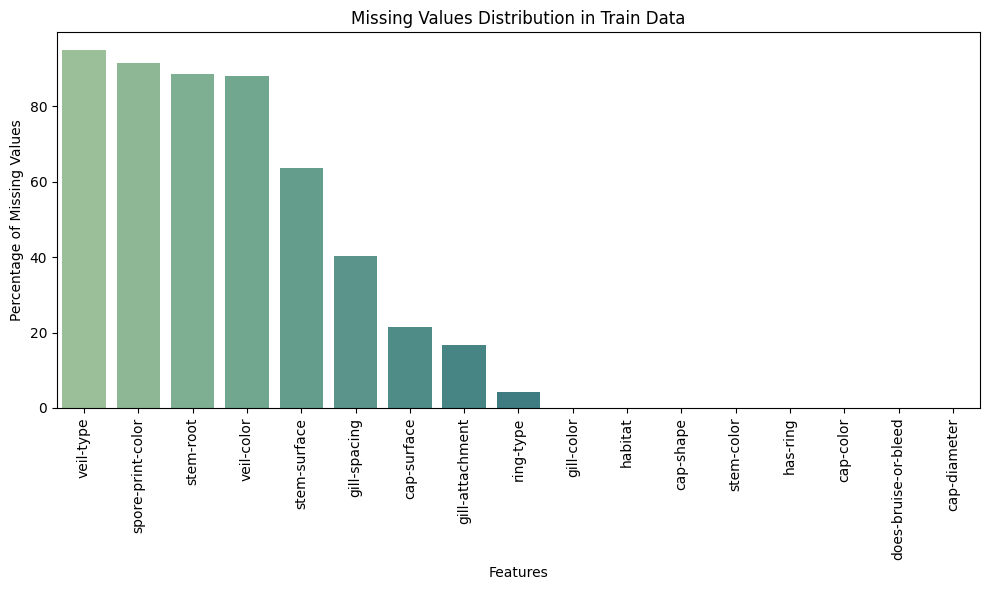

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate percentage of missing values
missing_values = train.isnull().mean() * 100
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)

# Plot missing values
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.barplot(x=missing_values.index, y=missing_values.values, palette='crest')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in Train Data')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [25]:
import pandas as pd
import numpy as np
import gc


# Calculate missing value percentages
missing_values_train = train.isnull().mean() * 100
missing_values_test = test.isnull().mean() * 100

# Identify columns with more than 95% missing values
cols_to_drop_train = missing_values_train[missing_values_train > 95].index
cols_to_drop_test = missing_values_test[missing_values_test > 95].index

# Drop columns from train and test DataFrames
train = train.drop(columns=cols_to_drop_train)
test = test.drop(columns=cols_to_drop_test)

# Clean up memory
gc.collect()



0

In [26]:
from sklearn.impute import KNNImputer
import pandas as pd

def knn_impute(train, n_neighbors=5):
    # Make a copy of the DataFrame to avoid modifying the original data
    df_encoded = train.copy()
    
    # Encode categorical columns
    cat_columns = df_encoded.select_dtypes(include='object').columns
    cat_mapping = {col: dict(enumerate(df_encoded[col].astype('category').cat.categories)) for col in cat_columns}
    for col in cat_columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    
    # Apply KNN imputation
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed_encoded = knn_imputer.fit_transform(df_encoded)
    
    # Convert the imputed data back to a DataFrame
    df_imputed = pd.DataFrame(df_imputed_encoded, columns=df_encoded.columns)
    
    # Decode categorical columns
    for col in cat_columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(cat_mapping[col])
    
    return df_imputed



In [27]:

# Apply KNN imputation
train_imputed = knn_impute(train, n_neighbors=5)
test_imputed = knn_impute(test, n_neighbors=5)



In [28]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

# Assuming df_train_imputed and df_test_imputed are already defined and imputed

# Identify categorical columns in the training set, excluding the target column
cat_cols_train = train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform the training data
train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(train_imputed[cat_cols_train].astype(str))

# Transform the test data
test_imputed[cat_cols_train] = ordinal_encoder.transform(test_imputed[cat_cols_train].astype(str))


In [29]:
train_imputed.head()


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,53.0,73.0,73.0,8.0,44.0,28.0,60.0,4.51,...,27.0,48.0,56.0,15.0,15.0,5.0,18.0,21.0,25.0,0.0
1,p,4.51,72.0,56.0,65.0,8.0,44.0,28.0,46.0,4.79,...,27.0,59.0,48.0,15.0,15.0,19.0,40.0,21.0,25.0,3.0
2,e,6.94,53.0,73.0,49.0,8.0,76.0,28.0,60.0,6.85,...,27.0,52.0,46.0,15.0,15.0,5.0,18.0,21.0,36.0,3.0
3,e,3.88,53.0,82.0,57.0,8.0,71.0,41.0,37.0,4.16,...,27.0,48.0,56.0,15.0,15.0,5.0,18.0,21.0,25.0,2.0
4,e,5.85,72.0,65.0,75.0,8.0,47.0,41.0,60.0,3.37,...,27.0,48.0,56.0,15.0,15.0,5.0,18.0,21.0,29.0,0.0


In [30]:
test_imputed.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,72.0,68.0,63.0,21.0,65.0,41.0,60.0,11.13,17.12,15.0,48.0,56.0,20.0,22.0,19.0,19.0,21.0,25.0,0.0
1,6.90,64.0,77.0,65.0,8.0,65.0,28.0,62.0,1.27,10.75,27.0,48.0,46.0,15.0,15.0,5.0,18.0,21.0,25.0,0.0
2,2.00,48.0,55.0,63.0,8.0,65.0,28.0,46.0,6.18,3.14,27.0,48.0,46.0,15.0,15.0,5.0,18.0,21.0,25.0,1.0
3,3.47,72.0,77.0,63.0,8.0,71.0,28.0,46.0,4.98,8.51,27.0,48.0,56.0,15.0,14.0,19.0,40.0,21.0,25.0,2.0
4,6.17,72.0,56.0,77.0,8.0,67.0,41.0,62.0,6.73,13.70,27.0,48.0,58.0,15.0,23.0,19.0,26.0,21.0,25.0,2.0


In [31]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming 'train' is your DataFrame and 'class' is the target column

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the 'class' column_imputed
train_imputed['class'] = le.fit_transform(train_imputed['class'])

# STEP 4: Data Analysis

In [32]:
!pip install dython

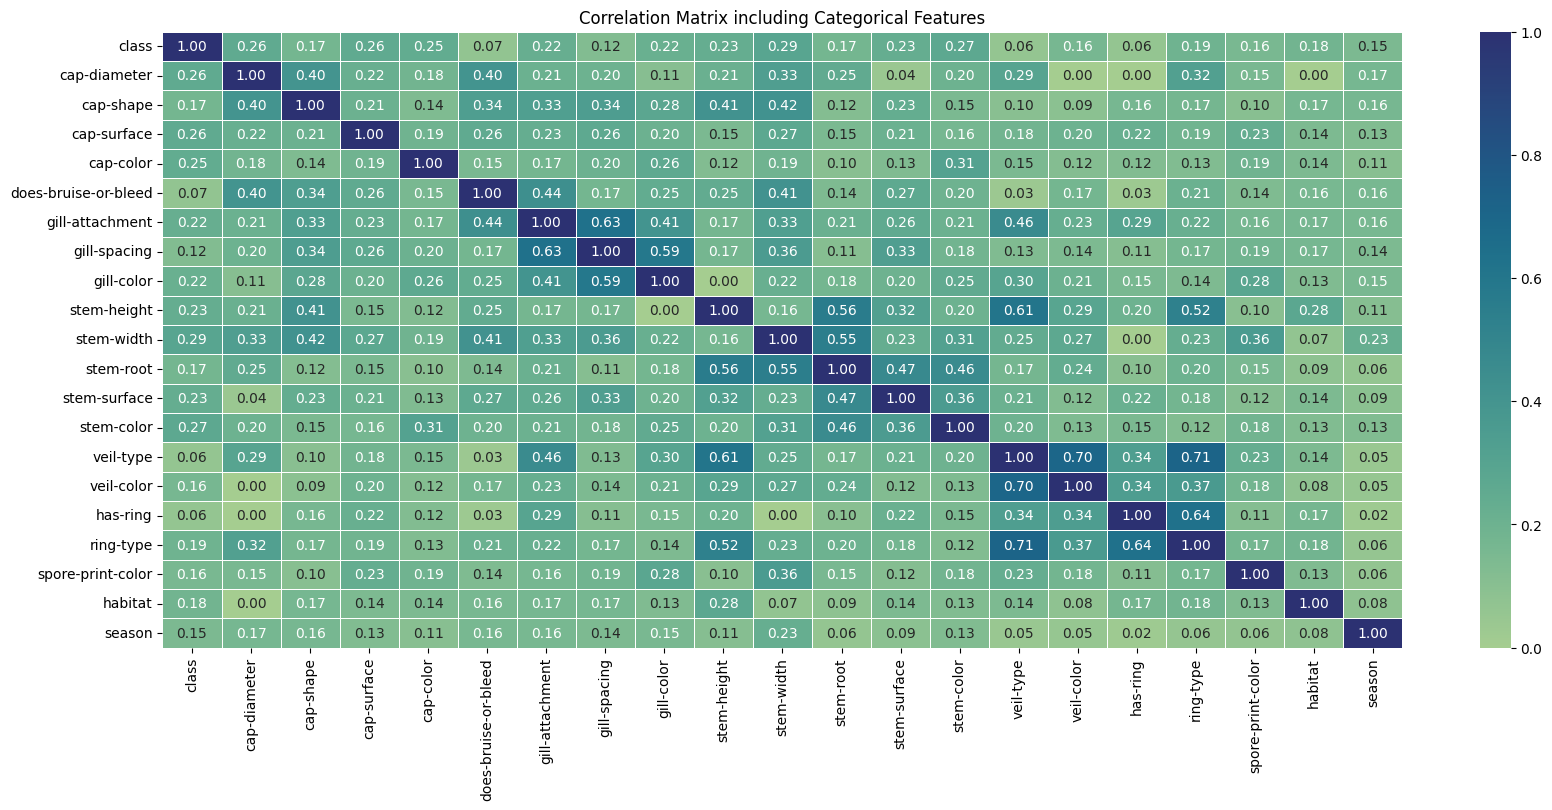

In [33]:
from dython.nominal import associations

associations_df = associations(train_imputed[:10000], nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFFFF') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='crest', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

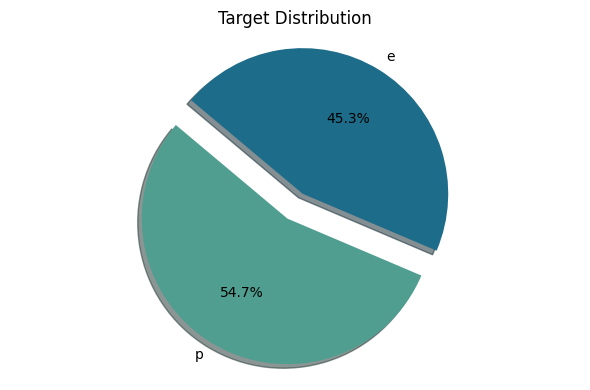

In [34]:
import matplotlib.pyplot as plt
import numpy as np


def plot_pie_chart(data, target, title, ax):
    # Calculate counts of each category
    data_counts = data[target].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    
    # Use the 'rocket' palette from Seaborn
    crest_palette = sns.color_palette('crest', n_colors=len(labels))
    colors = crest_palette.as_hex()  # Get hex color values
    
    # Define explode for a slight separation of slices
    explode = [0.1] * len(labels)  # Explode all slices for better visibility

    # Plot the pie chart
    wedges, texts, autotexts = ax.pie(
        sizes, 
        explode=explode, 
        labels=labels, 
        colors=colors, 
        autopct='%1.1f%%', 
        shadow=True, 
        startangle=140
    )
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.axis('equal') 
    
    # Title and legend customization
    ax.set_title(title)
    for text in texts:
        text.set_color('black')  # Set color of slice labels
    for autotext in autotexts:
        autotext.set_color('black')  # Set color of percentage labels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size as needed

# Plot the pie chart
plot_pie_chart(train_copy, "class", "Target Distribution", ax)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()





Numerical Columns (excluding target):
Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')


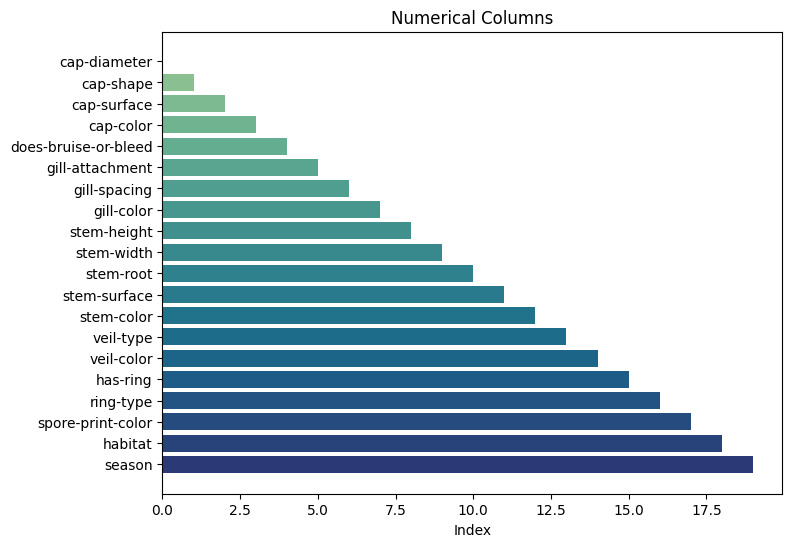

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Define the target column
target = 'class'

# Select numerical columns, excluding the target column if it's numerical
numerical_columns = train_imputed.select_dtypes(exclude=['object']).columns.drop(target, errors='ignore')

print("\nNumerical Columns (excluding target):")
print(numerical_columns)

# Visualize the categorical and numerical columns
def plot_column_names(columns, title, palette_name='crest'):
    plt.figure(figsize=(8, 6))
    colors = sns.color_palette(palette_name, len(columns))
    plt.barh(columns, range(len(columns)), color=colors)
    plt.xlabel('Index')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the first column on top
    plt.show()



# Plot numerical columns
plot_column_names(numerical_columns, 'Numerical Columns', palette_name='crest')


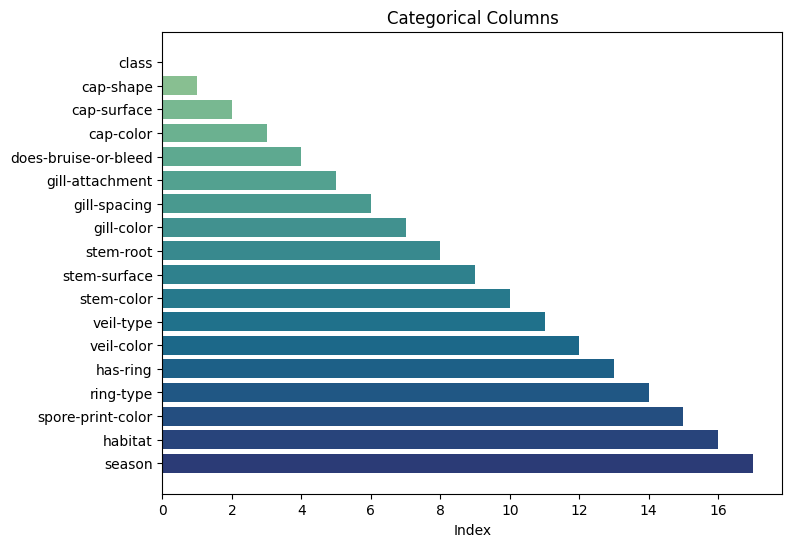

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Identify categorical columns
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Define plotting function
def plot_categorical_columns(columns, title, palette_name='crest'):
    plt.figure(figsize=(8, 6))
    colors = sns.color_palette(palette_name, len(columns))
    plt.barh(columns, range(len(columns)), color=colors)
    plt.xlabel('Index')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the first column on top
    plt.show()

# Plot categorical columns
plot_categorical_columns(categorical_columns, 'Categorical Columns', palette_name='crest')


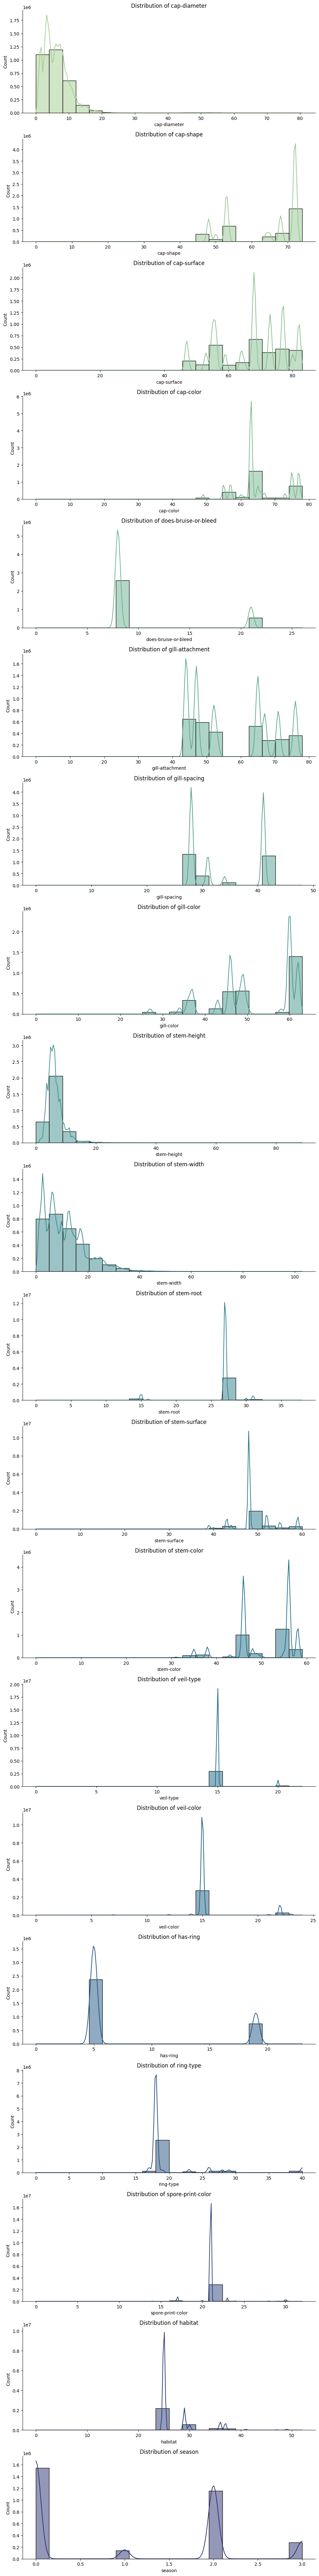

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

# Ensure you have the numerical columns list
numerical_columns = train_imputed.select_dtypes(exclude=['object']).columns.drop('class', errors='ignore')

# Obtain the "crest" colormap
cmap = plt.get_cmap('crest')

# Normalize the number of columns to fit the colormap
norm = Normalize(vmin=0, vmax=len(numerical_columns) - 1)

# Plot configuration
plt.figure(figsize=(10, len(numerical_columns) * 4))  # Adjust figure height based on the number of columns

# Loop over each numerical column and create a histogram plot
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i + 1)  # Create subplots based on the number of numerical columns
    
    # Determine the color for the histogram
    color = cmap(norm(i))
    
    # Create the histogram plot with the specified color
    sns.histplot(data=train_imputed, x=column, kde=True, bins=20, color=color)
    plt.title(f'Distribution of {column}')
    sns.despine()  # Remove spines for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlapping

# Save the plot to a file if necessary
# plt.savefig('numerical_columns_distribution.png', dpi=300)

plt.show()


Categorical Columns: Index(['class', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color',
       'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')
Column: class
Filtered Categories: Index(['p', 'e'], dtype='object', name='class')
Filtered Data Shape: (3116945, 22)


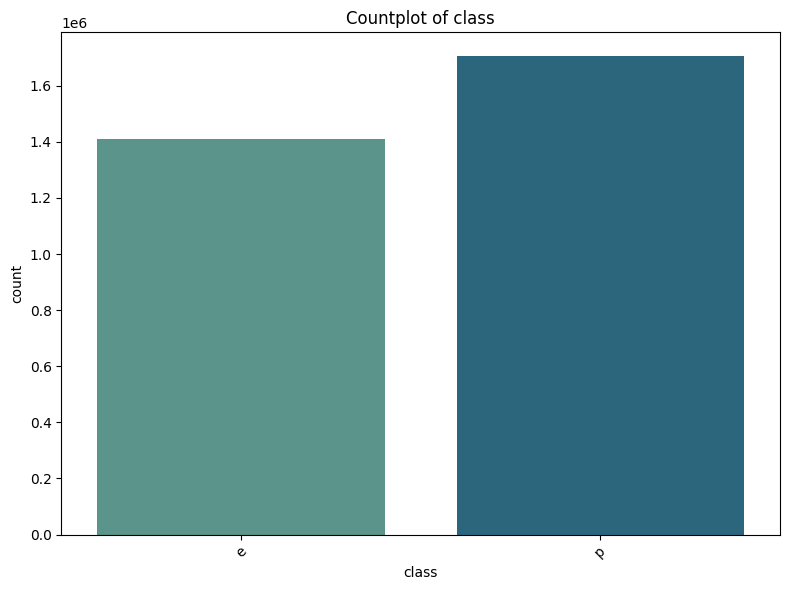

Column: cap-shape
Filtered Categories: Index(['x', 'f', 's', 'b', 'o', 'p', 'c', 'd', 'e', 'n', 't', 'w', 'g', 'y',
       'r', 'a'],
      dtype='object', name='cap-shape')
Filtered Data Shape: (3116745, 22)


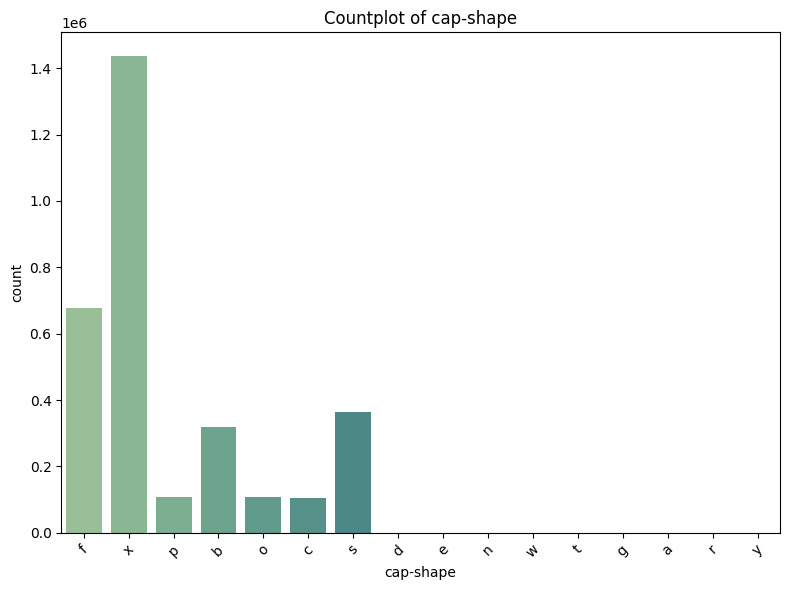

Column: cap-surface
Filtered Categories: Index(['t', 's', 'y', 'h', 'g', 'd', 'k', 'e', 'i', 'w', 'l', 'n', 'f', 'p',
       'u', 'a', 'm', 'o', 'r', 'x', 'c'],
      dtype='object', name='cap-surface')
Filtered Data Shape: (2445823, 22)


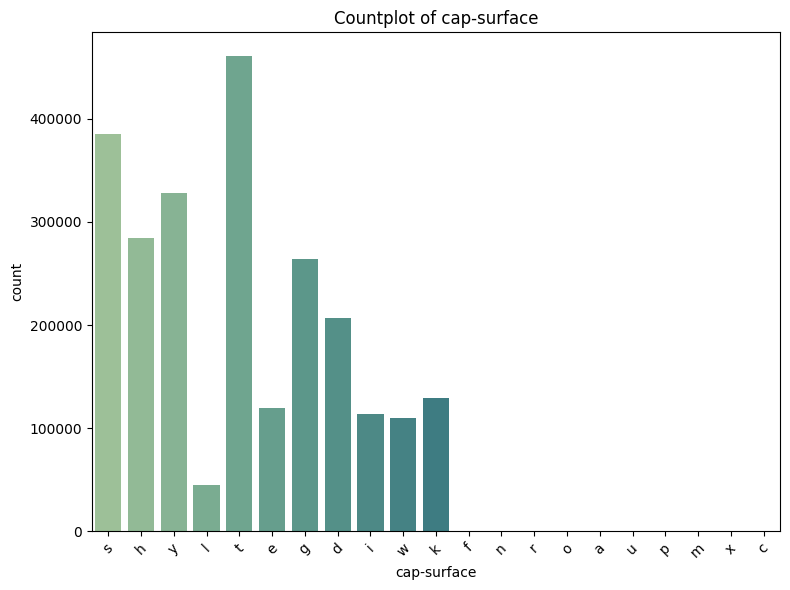

Column: cap-color
Filtered Categories: Index(['n', 'y', 'w', 'g', 'e', 'o', 'p', 'r', 'u', 'b', 'k', 'l', 'f', 'd',
       's', 'a'],
      dtype='object', name='cap-color')
Filtered Data Shape: (3116748, 22)


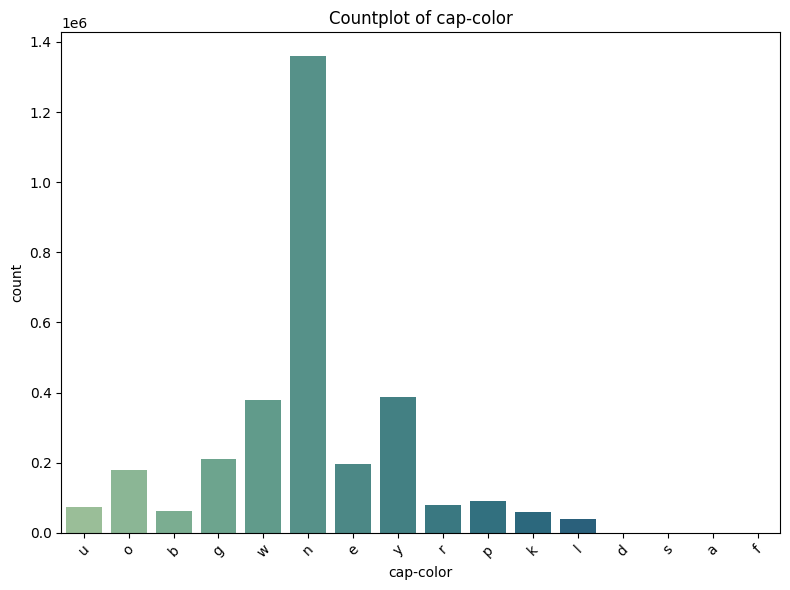

Column: does-bruise-or-bleed
Filtered Categories: Index(['f', 't'], dtype='object', name='does-bruise-or-bleed')
Filtered Data Shape: (3116828, 22)


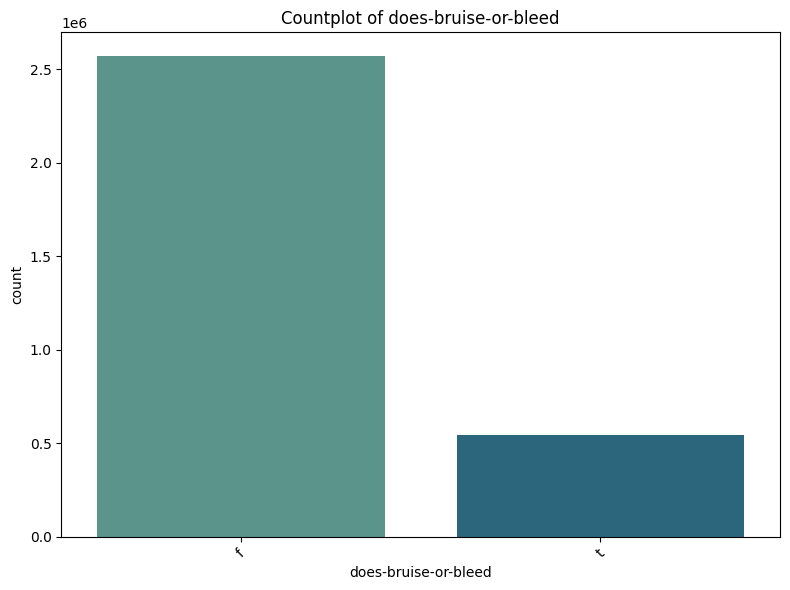

Column: gill-attachment
Filtered Categories: Index(['a', 'd', 'x', 'e', 's', 'p', 'f', 'c', 'u', 'w', 't', 'k'], dtype='object', name='gill-attachment')
Filtered Data Shape: (2592744, 22)


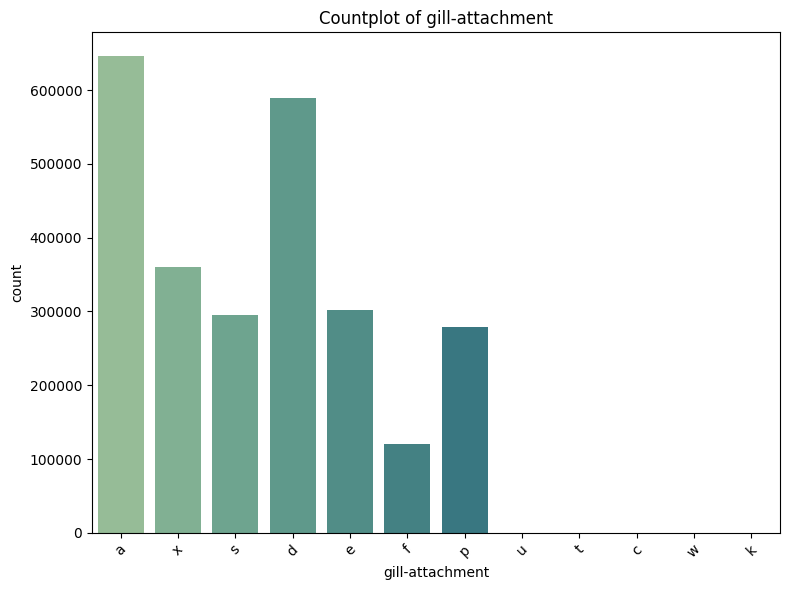

Column: gill-spacing
Filtered Categories: Index(['c', 'd', 'f'], dtype='object', name='gill-spacing')
Filtered Data Shape: (1858366, 22)


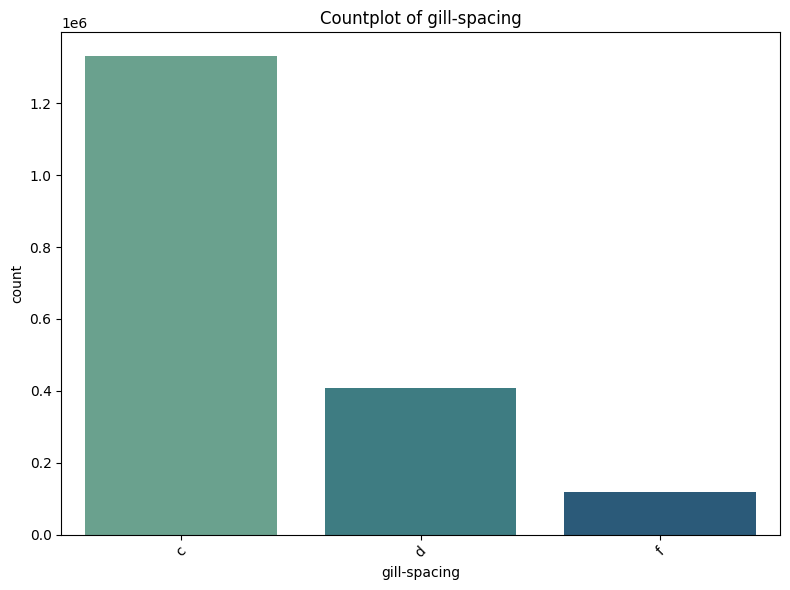

Column: gill-color
Filtered Categories: Index(['w', 'n', 'y', 'p', 'g', 'o', 'k', 'f', 'r', 'e', 'b', 'u', 'l', 'd',
       't', 's', 'x', 'c'],
      dtype='object', name='gill-color')
Filtered Data Shape: (3116728, 22)


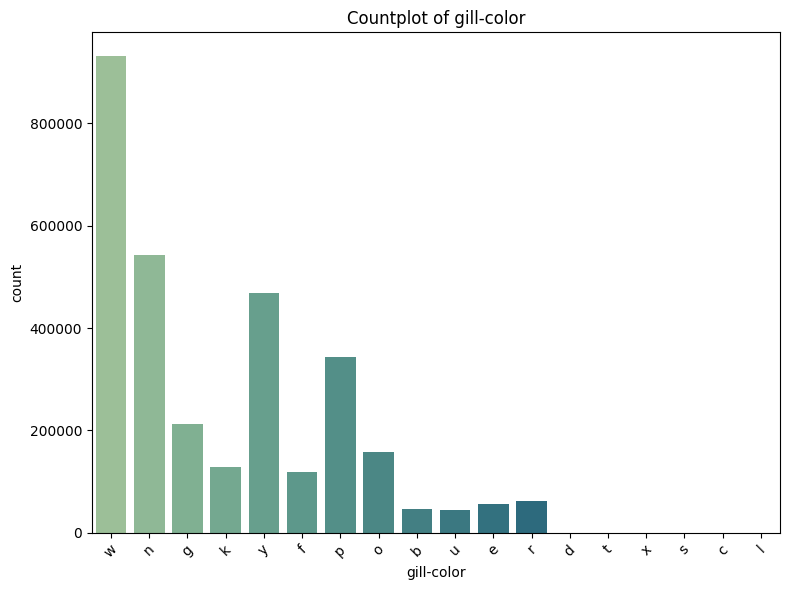

Column: stem-root
Filtered Categories: Index(['b', 's', 'r', 'c', 'f'], dtype='object', name='stem-root')
Filtered Data Shape: (359739, 22)


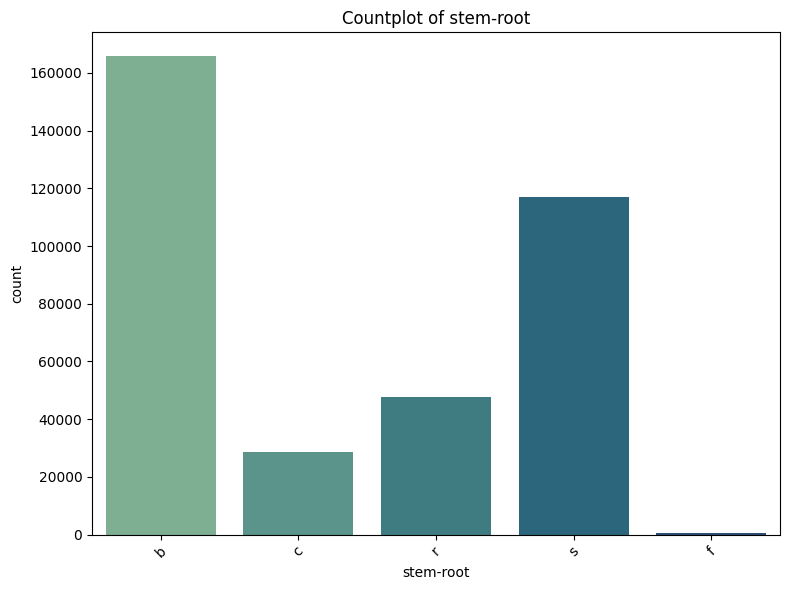

Column: stem-surface
Filtered Categories: Index(['s', 'y', 'i', 't', 'g', 'k', 'h', 'f', 'w', 'd', 'e', 'n'], dtype='object', name='stem-surface')
Filtered Data Shape: (1135855, 22)


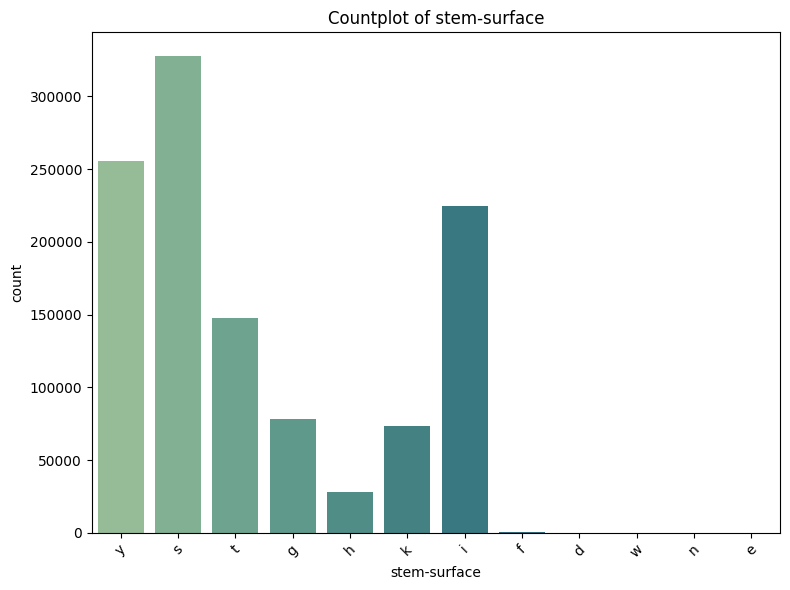

Column: stem-color
Filtered Categories: Index(['w', 'n', 'y', 'g', 'o', 'e', 'u', 'p', 'k', 'r', 'l', 'b', 'f', 's',
       't', 'a'],
      dtype='object', name='stem-color')
Filtered Data Shape: (3116776, 22)


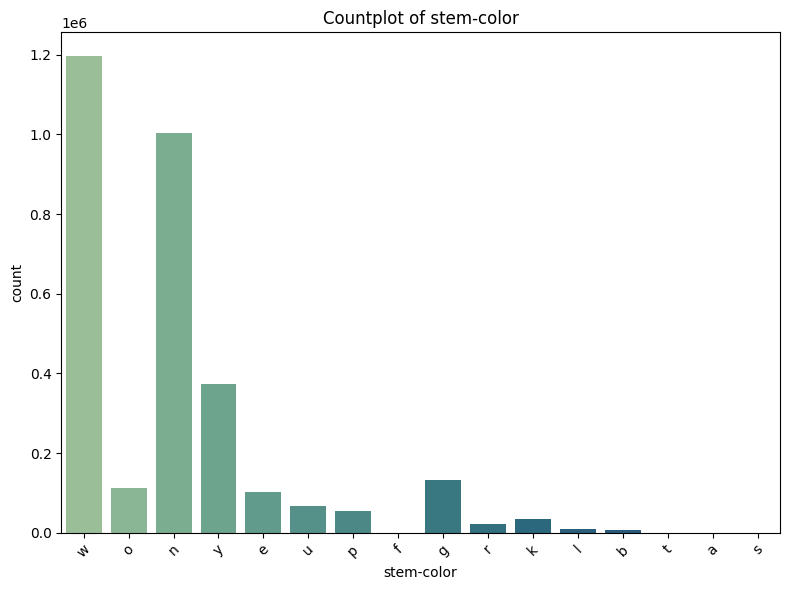

Column: veil-type
Filtered Categories: Index(['u'], dtype='object', name='veil-type')
Filtered Data Shape: (159373, 22)


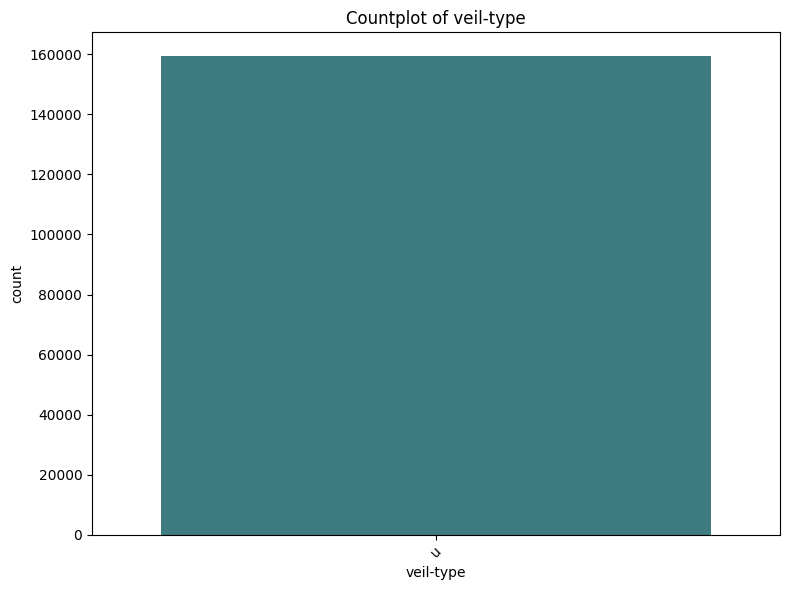

Column: veil-color
Filtered Categories: Index(['w', 'y', 'n', 'u', 'k', 'e', 'g'], dtype='object', name='veil-color')
Filtered Data Shape: (375887, 22)


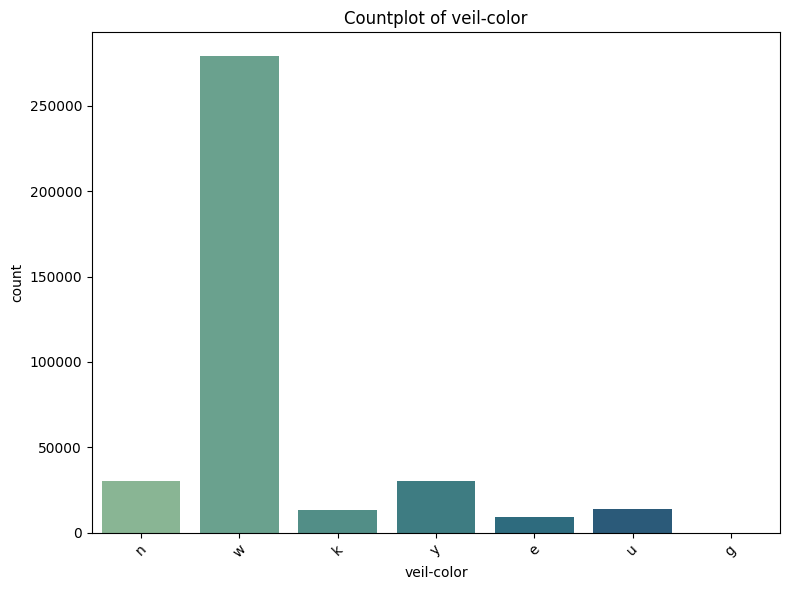

Column: has-ring
Filtered Categories: Index(['f', 't'], dtype='object', name='has-ring')
Filtered Data Shape: (3116802, 22)


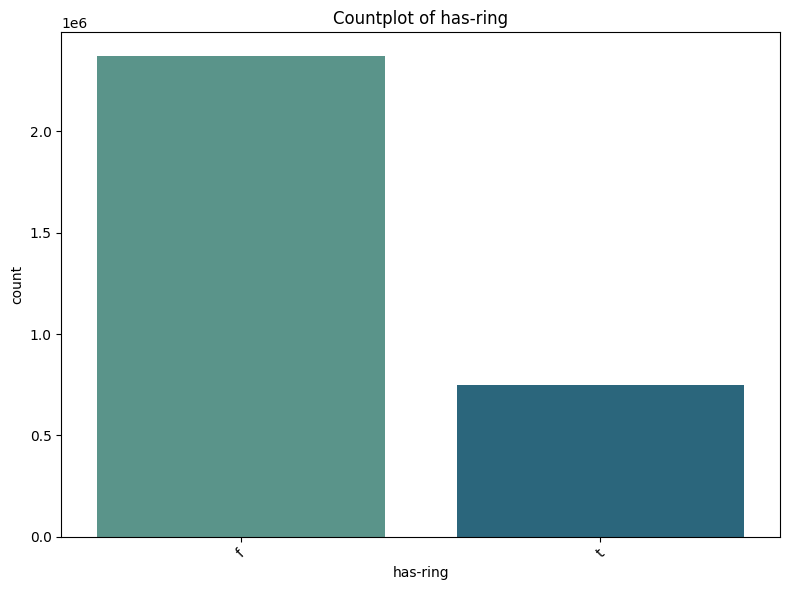

Column: ring-type
Filtered Categories: Index(['f', 'e', 'z', 'l', 'r', 'p', 'g', 'm', 't', 'd', 'n', 'x'], dtype='object', name='ring-type')
Filtered Data Shape: (2987866, 22)


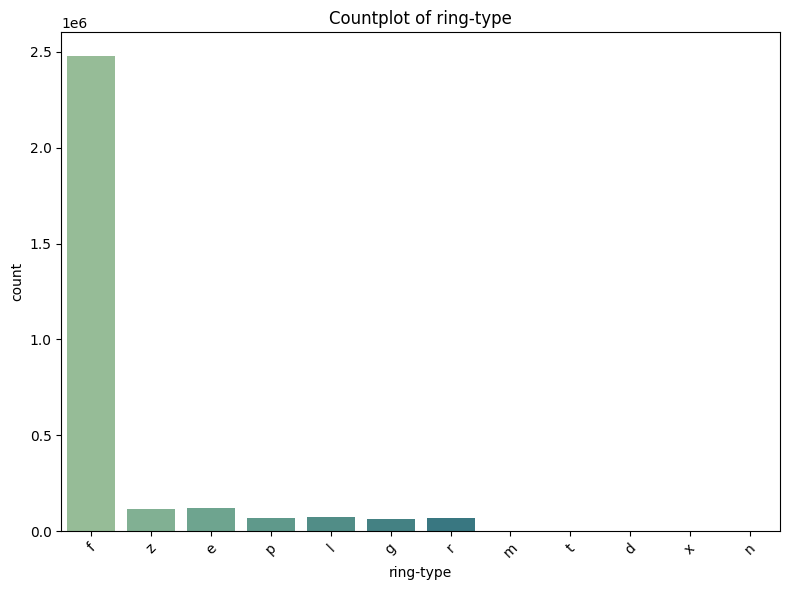

Column: spore-print-color
Filtered Categories: Index(['k', 'p', 'w', 'n', 'r', 'u', 'g', 'y'], dtype='object', name='spore-print-color')
Filtered Data Shape: (267125, 22)


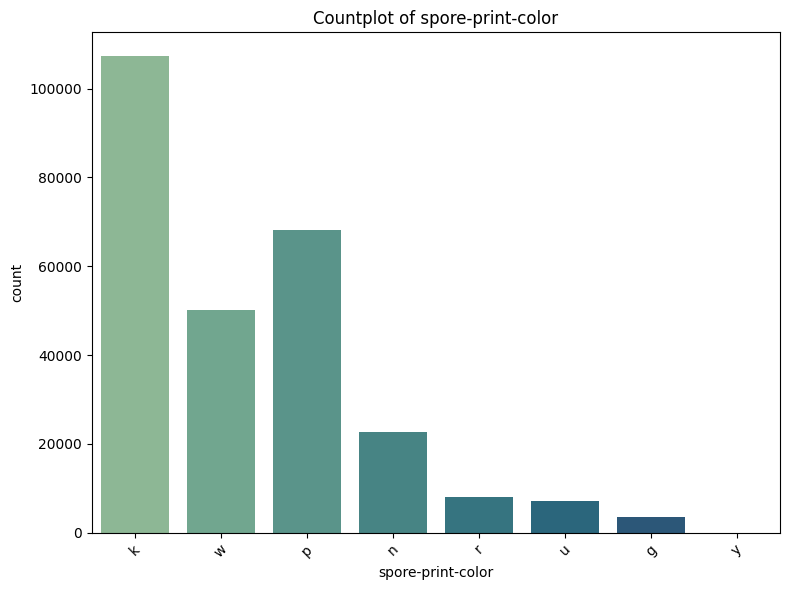

Column: habitat
Filtered Categories: Index(['d', 'g', 'l', 'm', 'h', 'w', 'p', 'u', 'e', 's', 'n', 't', 'r', 'y',
       'a', 'k'],
      dtype='object', name='habitat')
Filtered Data Shape: (3116778, 22)


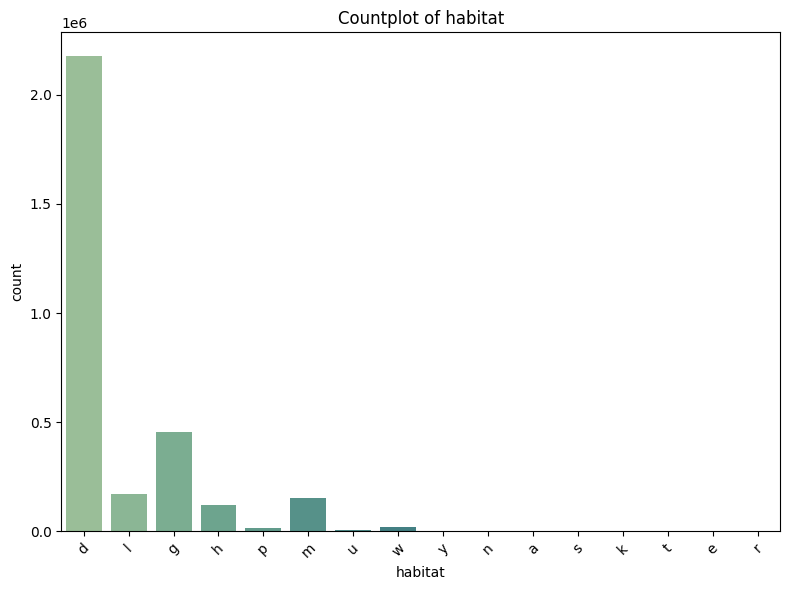

Column: season
Filtered Categories: Index(['a', 'u', 'w', 's'], dtype='object', name='season')
Filtered Data Shape: (3116945, 22)


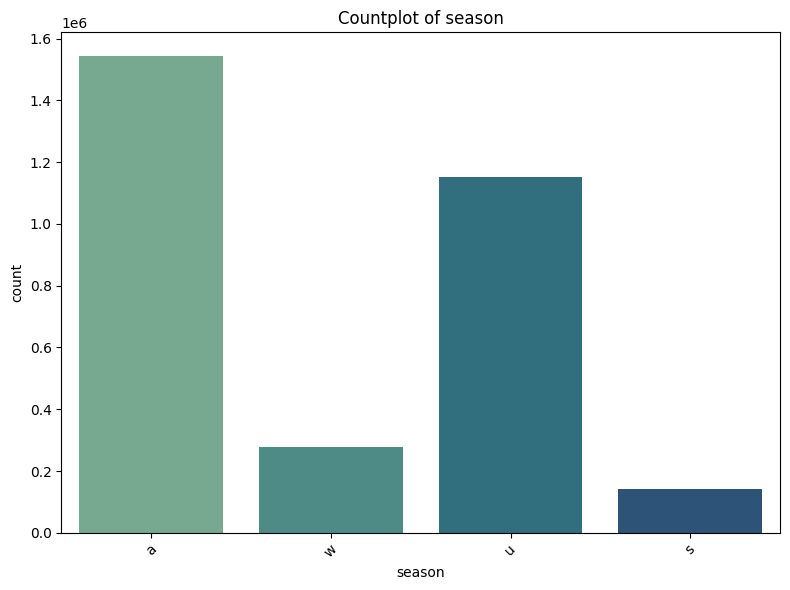

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')

# Define the categorical columns
categorical_columns = train.select_dtypes(include=['object']).columns

# Print categorical columns to ensure they are correctly identified
print(f"Categorical Columns: {categorical_columns}")

# Create count plots for categorical columns
for column in categorical_columns:
    plt.figure(figsize=(8, 6))  # Increase figure size if necessary
    
    # Filter out categories with value counts less than 70
    filtered_data = train[column].value_counts()
    filtered_categories = filtered_data[filtered_data >= 30].index
    
    # Subset DataFrame to include only relevant categories
    filtered_df = train[train[column].isin(filtered_categories)]
    
    # Check the filtered data to ensure it’s correct
    print(f"Column: {column}")
    print(f"Filtered Categories: {filtered_categories}")
    print(f"Filtered Data Shape: {filtered_df.shape}")
    
    # Create the count plot
    sns.countplot(data=filtered_df, x=column, palette='crest')  # Use 'viridis' color palette
    plt.title(f'Countplot of {column}')
    plt.xticks(rotation=45)  # Rotate x labels if necessary
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Show plot
    plt.show()

# STEP 5: Data Modeling

In [40]:
train = train_imputed
test = test_imputed

In [41]:
test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,72.0,68.0,63.0,21.0,65.0,41.0,60.0,11.13,17.12,15.0,48.0,56.0,20.0,22.0,19.0,19.0,21.0,25.0,0.0
1,6.90,64.0,77.0,65.0,8.0,65.0,28.0,62.0,1.27,10.75,27.0,48.0,46.0,15.0,15.0,5.0,18.0,21.0,25.0,0.0
2,2.00,48.0,55.0,63.0,8.0,65.0,28.0,46.0,6.18,3.14,27.0,48.0,46.0,15.0,15.0,5.0,18.0,21.0,25.0,1.0
3,3.47,72.0,77.0,63.0,8.0,71.0,28.0,46.0,4.98,8.51,27.0,48.0,56.0,15.0,14.0,19.0,40.0,21.0,25.0,2.0
4,6.17,72.0,56.0,77.0,8.0,67.0,41.0,62.0,6.73,13.70,27.0,48.0,58.0,15.0,23.0,19.0,26.0,21.0,25.0,2.0


In [42]:
X = train.drop(['class'],axis=1)
y = train['class'] 

In [43]:
X_train,X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state =42,stratify=y)

In [44]:
from sklearn.metrics import matthews_corrcoef

In [45]:

def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [46]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


# Define your XGBClassifier with the desired hyperparameters
model = XGBClassifier(
    alpha=0.1,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='binary:logistic',
    max_depth=14,
    min_child_weight=7,
    gamma=1e-6,
    n_estimators=100
)

# Fit the model with custom MCC metric
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=mcc_metric,
    verbose=True  # Print evaluation results during training
)


[0]	validation_0-logloss:0.46304	validation_0-mcc:0.93019
[1]	validation_0-logloss:0.35431	validation_0-mcc:0.95693
[2]	validation_0-logloss:0.26486	validation_0-mcc:0.96703
[3]	validation_0-logloss:0.21065	validation_0-mcc:0.97254
[4]	validation_0-logloss:0.17147	validation_0-mcc:0.97550
[5]	validation_0-logloss:0.14002	validation_0-mcc:0.97640
[6]	validation_0-logloss:0.11683	validation_0-mcc:0.97726
[7]	validation_0-logloss:0.09522	validation_0-mcc:0.97938
[8]	validation_0-logloss:0.08194	validation_0-mcc:0.97989
[9]	validation_0-logloss:0.07133	validation_0-mcc:0.98045
[10]	validation_0-logloss:0.06181	validation_0-mcc:0.98150
[11]	validation_0-logloss:0.05740	validation_0-mcc:0.98160
[12]	validation_0-logloss:0.05230	validation_0-mcc:0.98175
[13]	validation_0-logloss:0.04916	validation_0-mcc:0.98202
[14]	validation_0-logloss:0.04557	validation_0-mcc:0.98253
[15]	validation_0-logloss:0.04449	validation_0-mcc:0.98264
[16]	validation_0-logloss:0.04264	validation_0-mcc:0.98291
[17]	va

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1e-06, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [47]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9922023006501558
Confusion Matrix:
[[280207   2103]
 [  2758 338321]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    282310
           1       0.99      0.99      0.99    341079

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389



In [48]:
score = matthews_corrcoef(y_test, y_pred)
print('MCC:', score)

MCC: 0.9842701108314986


In [50]:
from xgboost import XGBClassifier

# Define and train the model
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
test_pred_prob = XGB.predict(test)

In [51]:
test_pred_prob

array([0, 1, 1, ..., 1, 0, 0])

In [52]:
#test_pred_binary = (test_pred_prob > 0.5).astype(int)
test_pred_class = le.inverse_transform(test_pred_prob)

In [53]:

sub['class']= test_pred_class

# FINAL SUBMISSION

In [54]:
sub.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e


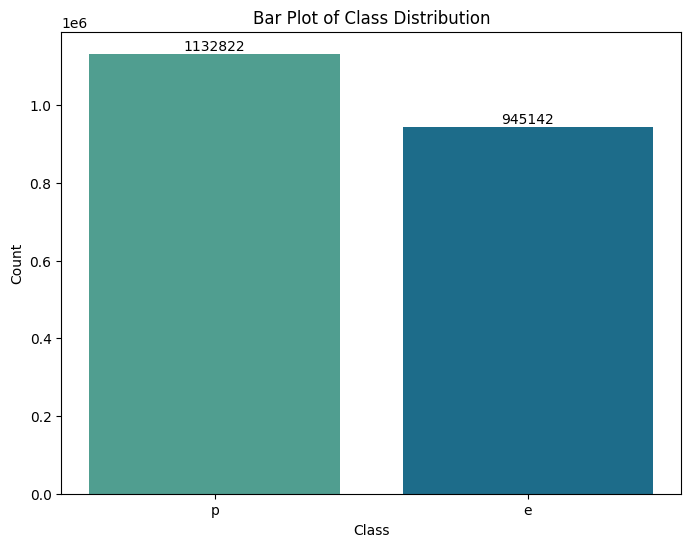

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Calculate the counts of each class
class_counts = sub['class'].value_counts()

# Set the color palette
palette = sns.color_palette("crest", n_colors=len(class_counts))

# Create a bar plot with seaborn color palette
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts.values, color=palette)  # Use the seaborn palette

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Add titles and labels
plt.title('Bar Plot of Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Show the plot
plt.show()
